In [2]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import os, sys, socket

import tensorflow as tf
from PIL import Image

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input, Conv2D, Flatten
from keras.layers import Concatenate
from keras.utils import np_utils
from keras.optimizers import SGD, Adam

In [22]:
# train_ds = keras.utils.image_dataset_from_directory(
#     directory='train_bw/',
#     labels='inferred',
#     label_mode='categorical',
#     color_mode='grayscale',
#     # batch_size=100,
#     image_size=(800, 600))

# validation_ds = keras.utils.image_dataset_from_directory(
#     directory='test_bw',
#     labels='inferred',
#     label_mode='categorical',
#     color_mode='grayscale',
#     # batch_size=75,
#     image_size=(800, 600))

In [14]:
def data_generator(type="train", batchsize=100):
    if type == "train":
        print("Loading Training data...")
        filepath = os.path.join("./data", "train_bw")
        rng = 299

    elif type == "valid":
        print("Loading Validation data...")
        filepath = os.path.join("./data", "test_bw")
        rng = 14

    for _ in range(70):
        for i, folder in enumerate(['down', 'up', 'left', 'right', 'x']):
            cur_filepath = os.path.join(filepath, folder)
            X1 = []
            X2 = []
            target = []

            for j in range(rng):
                X1.append(np.expand_dims(np.asarray(Image.open(os.path.join(cur_filepath, f'{folder}_{j}.jpg'))), axis=2))
                X2.append(np.expand_dims(np.asarray(Image.open(os.path.join(cur_filepath, f'{folder}_{j+1}.jpg'))), axis=2))
                target.append(np_utils.to_categorical(i, 5))
                if len(X1) == batchsize:
                    yield {'input1':np.asarray(X1) , 'input2':np.asarray(X2)},  {'out':np.asarray(target)}
                    X1 = []
                    X2 = []
                    target = []

In [15]:
data_train = data_generator("train", 100)
data_valid = data_generator("valid", 15)

In [16]:
data_train.__next__()[0]['input1'].shape

Loading Training data...


(100, 600, 800, 1)

In [17]:
# Input data.
input1   = Input(shape=(800,600, 1), dtype='float32', name='input1')
input2   = Input(shape=(800,600, 1), dtype='float32', name='input2')

nb_filter      = 64   
nb_row, nb_col = 5,5  
strides        = (3,3)
conv  =  Conv2D(nb_filter, (nb_row, nb_col), activation='relu', padding='same', strides=strides)
x1    = conv(input1) 
x2    = conv(input2)

# Flatten data: transform from (28,28) to (784,)
x1 = Flatten()(x1)
x2 = Flatten()(x2)

# Layer two: Single fully-connected layer applied to each input independently, with shared weights.
layer = Dense(256, activation='relu')
x1 = layer(x1)
x2 = layer(x2)
x = Concatenate()([x1, x2])

# More dense layers then output.
x   = Dense(1024, activation='relu')(x)
x   = Dense(512, activation='relu')(x)
x   = Dense(128, activation='relu')(x)
x   = Dense(64, activation='relu')(x)
out = Dense(5, activation='softmax', name='out')(x)
model = Model(inputs=[input1, input2], outputs=[out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 800, 600, 1  0           []                               
                                )]                                                                
                                                                                                  
 input2 (InputLayer)            [(None, 800, 600, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 267, 200, 64  1664        ['input1[0][0]',                 
                                )                                 'input2[0][0]']             

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    os.path.join("./models", "model.h5"),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

# earlystop = EarlyStopping(
#     monitor='val_loss',
#     min_delta=0,
#     patience=20,
#     verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, learning_rate_reduction]

In [19]:
optimizer = Adam(lr=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08) # Optimization hyperparameters.

model.compile(optimizer=optimizer,
              loss={'out':'categorical_crossentropy'},
              loss_weights={'out': 1.0}, # 
              metrics=['accuracy'])

c:\Users\sadma\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
# Callbacks can be used to stop early, decrease learning rate, checkpoint the model, etc.
#from keras.callbacks import EarlyStopping
#stopping  = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
# callbacks = []#[stopping]

# The fit_generator function loads data batches on the fly, instead of transfering entire data set to the gpu.
history   = model.fit(data_train,
                        steps_per_epoch=int(1500/100),
                        epochs=70, verbose=1,
                        callbacks=callbacks, 
                        validation_data=data_valid,
                        validation_steps=int(75/15))

Epoch 1/70
15/15 [==============================] - ETA: 0s - loss: 22720.6641 - accuracy: 0.1333Loading Validation data...

Epoch 1: val_loss improved from inf to 2042.31836, saving model to model.h5
15/15 [==============================] - 167s 11s/step - loss: 22720.6641 - accuracy: 0.1333 - val_loss: 2042.3184 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/70
15/15 [==============================] - ETA: 0s - loss: 763.7047 - accuracy: 0.2120
Epoch 2: val_loss improved from 2042.31836 to 18.61326, saving model to model.h5
15/15 [==============================] - 156s 11s/step - loss: 763.7047 - accuracy: 0.2120 - val_loss: 18.6133 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/70
15/15 [==============================] - ETA: 0s - loss: 12.8546 - accuracy: 0.2060
Epoch 3: val_loss improved from 18.61326 to 3.84438, saving model to model.h5
15/15 [==============================] - 156s 11s/step - loss: 12.8546 - accuracy: 0.2060 - val_loss: 3.8444 - val_accuracy: 0.1333 - lr: 0.0010
Epoch 

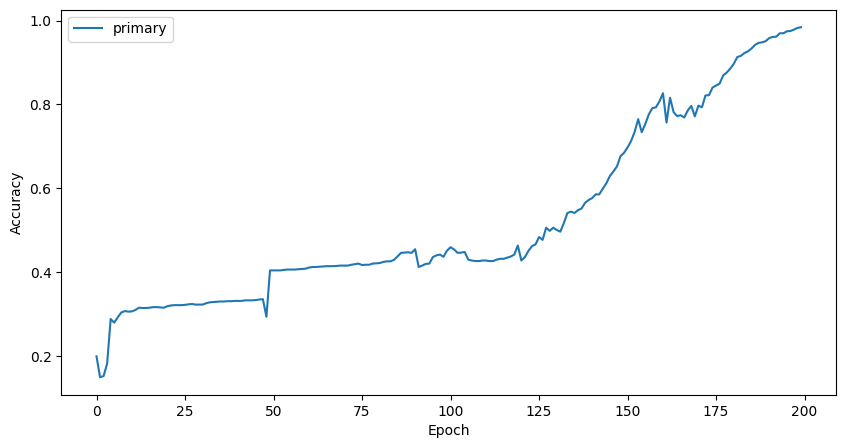

In [10]:
# Plot loss trajectory throughout training.
plt.figure(1, figsize=(10,5))
plt.plot(history.history['accuracy'], label='primary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [3]:
import numpy as np
from keras.models import load_model
from PIL import Image

# Load the saved model.
model = load_model('model.h5')

In [31]:
inputs = {}
img1 = np.transpose(np.asarray(Image.open("data/test_bw/up/up_0.jpg").convert('L')))
# img2 = np.expand_dims(np.transpose(np.asarray(Image.open("test_bw/x/x_2.jpg").convert('L'))), axis=-1)
print(img1.shape)

inputs['input1'] = np.reshape(img1, (1, 800, 600, 1))
inputs['input2'] = np.reshape(img1, (1, 800, 600, 1))
# inputs['input2'] = np.reshape(img2, (1, 800, 600, 1))


predictions = model.predict(inputs)
print("Predicted Class: ", np.argmax(predictions))

(800, 600)
1/1 [==============================] - 0s 270ms/step
Predicted Class:  1


In [ ]:
inputs, outputs = data_valid.__next__()